# Exam on Convolutional Neural Networks (CNN)

Welcome to the Convolutional Neural Networks (CNN) practical exam. In this exam, you will work on an image classification task to predict weather the parkinglot is occupied or empty. You are provided with a dataset of parkinglot images, and your task is to build, train, and evaluate a CNN model.

---

## Dataset Overview
### **Dataset:**
* Just run the command under the `Load Data` section to get the data downloaded and unzipped or you can access it [here](www.kaggle.com/datasets/khaledzsa/parkinglot-occupation)
### **Dataset Name:** ParkingLot Occupation

### **Description:**  
The dataset contains images of labeld parkinglot images for classification purposes. Each image belongs to one of the 2 classes, representing the label.

### **Labels:**
* `empty`
* `occupied`


## Load Data
Run the following command to get the data and unzip it, alternatively you can access the data [here](www.kaggle.com/datasets/khaledzsa/parkinglot-occupation).

In [1]:
!kaggle datasets download -d khaledzsa/parkinglot-occupation
!unzip parkinglot-occupation.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/parkinglot-occupation
License(s): unknown
  0% 0.00/5.21M [00:00<?, ?B/s]
100% 5.21M/5.21M [00:00<00:00, 176MB/s]
Archive:  parkinglot-occupation.zip
  inflating: ParkingLot_Occupation/test/empty/roi_004a880991fb418298519ca2616f3147_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_01a29d413e3642d39e11414dc6e95501_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_023ee6f9ea20407da126475ef5bfe567_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_03fffe90162c4e06be43e47f34d9e83a_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_04c6ff9e977d4f59bbf963bfb97f6872_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_0571fcbaa9b94ddfaf5c65edad33e59e_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_064a5abf3c7d47f9942f77da2a2af7e7_empty.jpg  
  inflating: ParkingLot_Occupation/test/empty/roi_066690ec6e534d9fbe6be7f9acffb48d_empty.jpg  
  inflating: ParkingLot_Occupation/

## Import Libraries

In [3]:
# Libraries for DA and visualization:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# Libraries and modules for DL model:
import tensorflow as tf
import keras
import os
from keras import models
from tensorflow.keras import layers
from keras import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ActivityRegularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from skimage.transform import resize

## Data Preprocessing
In this section, preprocess the dataset by:
- Loading the images from the file paths.
- Resizing the images to a consistent size.
- Normalizing pixel values.

Add more if needed!

In [4]:
# Before Loading the data let's see the size of our images:
from PIL import Image
image_dir = '/content/ParkingLot_Occupation/test/empty'

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

if len(image_files) > 0:
    sample_image_path = os.path.join(image_dir, image_files[0])
    image = Image.open(sample_image_path)
    print("Sample image size:", image.size)
else:
    print("No image files found in the directory.")

# We note that the image resolution is low, so when rezising our image we shouldn't really play with it's size by much.

Sample image size: (173, 64)


In [5]:
train_path = '/content/ParkingLot_Occupation/train'
test_path = '/content/ParkingLot_Occupation/test'
b_size = 100
height = 64  # Image height, we kept it at the same level.
width = 173  # Image Width, we kept it at the same level.

# First we'll set up the greyscaling:
class GrayscaleLayer(tf.keras.layers.Layer):
    def call(self, images):
        return tf.image.rgb_to_grayscale(images) # Here every image will be transformed into a grey image.

# Set up an enhanced data augmentation Pipeline:
data_augmentor = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),                   # randomly flip images.
    layers.RandomRotation(0.4),                                     # randomly rotate images by 40 degrees.
    layers.RandomZoom(0.4),                                         # randomly zoom in.
    layers.RandomContrast(0.4),                                     # randomly add noise to the image.
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Randomly translate images. (Will move the image horizantal and vertical level randomly)
    layers.RandomBrightness(0.2),                                   # Adjust brightness randomly
    layers.RandomCrop(height, width),                               # Randomly crop images
    layers.Rescaling(1./255)                                        # Normalize pixel values to (0,1) since pixle values start form 0 to 255.
])

# Custom Preprocessing Function:
def custom_preprocessing(image, label):
    image = data_augmentor(image)   # Our augmentor step.
    image = GrayscaleLayer()(image) # Grey scaling images.
    image = tf.image.resize(image, [173, 64])
    return image, label
# Load our datasits:
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(height, width),
    batch_size=b_size,
    seed=101,
    validation_split=0.15,  # 15% of data for validation
    subset='both'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(height, width),
    batch_size=b_size,
    seed=101
)

train_ds = train_val_ds[0].map(custom_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = train_val_ds[1].map(custom_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(custom_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# The icing on the cake
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# The above caching, shuffling, and prefetching steps boost performance by caching data in memory,
# shuffling to ensure randomness, and prefetching to overlap data preprocessing and model execution.

Found 1382 files belonging to 2 classes.
Using 1175 files for training.
Using 207 files for validation.
Found 344 files belonging to 2 classes.


## Data Splitting
In this section, we will split our dataset into three parts:

* `train` Folder: Training set (85%).
* `train` Folder: Validation set (15%).
* `test` Folder: Test set (100%).

In [ ]:
# already done in the step above

## Building the CNN Model
In this section, define the architecture of the CNN model. The architecture may consist of:
- Convolutional layers with max-pooling
- Dropout layers
- Flatten layer
- Dense layers
- Output layer

Add and remove any of these as needed!

In [23]:
# # In any given CNN model we'll have our convelutional layers first that process our images (matrixs) then we'll move on to our dense layer after flatting the matrixs into a vector.
# #Model 1:
# model = Sequential([
#     # A common convelutional layer has three steps, 1-The layer it's self, 2-Batch normalization and 3-Maxpooling.
#     # The Convelutional layer takes 3 main argumants: (filter, kernal, activation):
#     # First layer:
#     Conv2D(16, (3,3), activation = 'relu'),      # A common kernal filter used is a 3 X 3 matrix.
#     BatchNormalization(),                        # Normalizing each batch after passing the layer would make it more interptable to the second layer
#     MaxPooling2D(2,2),                           # Same with the kernal a 2 X 2 matrix that filters our layer picking the largest pixel in it.
#     # Second layer:
#     Conv2D(32, (3,3), activation = 'relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),
#     # Transition to our dense layer:
#     Flatten(),                                   # This step will shrink our matrixs into a vector.
#     # First Dense layer:
#     Dense(32, activation = 'relu'),
#     # Output layer:
#     Dense(1, activation = 'sigmoid')
# ])

In [13]:
# # In any given CNN model we'll have our convelutional layers first that process our images (matrixs) then we'll move on to our dense layer after flatting the matrixs into a vector.
# # Model 2: (we'll try to simplify the model)
# model = Sequential([
#     # A common convelutional layer has three steps, 1-The layer it's self, 2-Batch normalization and 3-Maxpooling.
#     # The Convelutional layer takes 3 main argumants: (filter, kernal, activation):
#     # First layer:
#     Conv2D(16, (3,3), activation = 'relu'),      # A common kernal filter used is a 3 X 3 matrix.
#     # BatchNormalization(),                        # Normalizing each batch after passing the layer would make it more interptable to the second layer
#     # MaxPooling2D(2,2),                           # Same with the kernal a 2 X 2 matrix that filters our layer picking the largest pixel in it.
#     # Second layer:
#     Conv2D(16, (3,3), activation = 'relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),
#     # Transition to our dense layer:
#     Flatten(),                                   # This step will shrink our matrixs into a vector.
#     # First Dense layer:
#     Dense(16, activation = 'relu'),
#     # Output layer:
#     Dense(1, activation = 'sigmoid')
# ])

In [34]:
# # In any given CNN model we'll have our convelutional layers first that process our images (matrixs) then we'll move on to our dense layer after flatting the matrixs into a vector.
# # Model 3: (we'll add regularization techniques)
# model = Sequential([
#     # A common convelutional layer has three steps, 1-The layer it's self, 2-Batch normalization and 3-Maxpooling.
#     # The Convelutional layer takes 3 main argumants: (filter, kernal, activation):
#     # First layer:
#     Conv2D(32, (3,3), activation = 'relu'),      # A common kernal filter used is a 3 X 3 matrix.
#     BatchNormalization(),                        # Normalizing each batch after passing the layer would make it more interptable to the second layer
#     MaxPooling2D(2,2),                           # Same with the kernal a 2 X 2 matrix that filters our layer picking the largest pixel in it.
#     Dropout(0.2),
#     # Second layer:
#     Conv2D(16, (3,3), activation = 'relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),
#     Dropout(0.2),
#     # Transition to our dense layer:
#     Flatten(),                                   # This step will shrink our matrixs into a vector.
#     # First Dense layer:
#     Dense(16, activation = 'relu'),
#     # Second Dense layer:
#     Dense(32, activation = 'relu'),
#     # Output layer:
#     Dense(1, activation = 'sigmoid')
# ])

In [39]:
# # In any given CNN model we'll have our convelutional layers first that process our images (matrixs) then we'll move on to our dense layer after flatting the matrixs into a vector.
# # Model 4: (we'll retrace our steps with a really simple model.)
# model = Sequential([
#      Conv2D(16, (3,3), activation = 'relu'),
#      Conv2D(32, (3,3), activation = 'relu'),
#      Flatten(),
#      Dense(32, activation = 'relu'),
#      Dense(1, activation = 'sigmoid')
# ])

In [45]:
# In any given CNN model we'll have our convelutional layers first that process our images (matrixs) then we'll move on to our dense layer after flatting the matrixs into a vector.
# Model 5: (we'll add a little bit more complexity.)
model = Sequential([
     Conv2D(16, (3,3), activation = 'relu'),
     Conv2D(32, (3,3), activation = 'relu'),
     Conv2D(32, (3,3), activation = 'relu'),
     Flatten(),
     Dense(16, activation = 'relu'),
     Dense(32, activation = 'relu'),
     Dense(1, activation = 'sigmoid')
])

## Training the Model
Train the CNN model using the training data and validate it on the validation set.

In [46]:
# Before training we must compile the model:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
# Check the summary for the model:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
# fit the model:
history = model.fit(train_ds,epochs = 25, validation_data = val_ds)

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5159 - loss: 1.9334 - val_accuracy: 0.7729 - val_loss: 0.6798
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 288ms/step - accuracy: 0.6828 - loss: 0.6806 - val_accuracy: 0.6763 - val_loss: 0.6565
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.6625 - loss: 0.6286 - val_accuracy: 0.7826 - val_loss: 0.5402
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.7173 - loss: 0.6211 - val_accuracy: 0.8454 - val_loss: 0.5118
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.8489 - loss: 0.4629 - val_accuracy: 0.7150 - val_loss: 0.5969
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.8475 - loss: 0.4199 - val_accuracy: 0.8647 - val_loss: 0.4170
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.8949 - loss: 0.3058 - val_accuracy: 0.8164 - val_loss: 0.4390
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.8658 - loss: 0.3339 - val_accuracy: 0.7

In [ ]:
# Model progression:
# Model 1: it seems like the model is over fitting with an accuracy score on training reaching 95% while the validation reached 70%, before trying regularization techniques.
# Model 2: A better performance with the model capping at epoch 9 with 90% in traininf and 81% on val, next up I'll add regularization techniques.
# Model 3: Model three is overfitting.
# Model 4: Performed great, we'll add more epochs to get a better evalution.
# Model 5: Fit great with a validation accuracy reaching 90% with the train accuracy 92%.

## Evaluate the Model
Evaluate the performance of the model on the test set.

In [49]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8961 - loss: 0.5041


[0.5635673403739929, 0.8895348906517029]

## Make Predictions
Use the trained model to make predictions on new or unseen parkinglot images.

if you need new, we prepared some data for you [here](www.kaggle.com/datasets/khaledzsa/parkinglot-occupation), or you can simply run the following command to get the data and unzip it.

<small>Note: please note that the file contain MetaData to tell you what each image contains <b>THIS IS JUST FOR YOU TO MAKE SURE</b></smmall>

If you ran the command above, you should have a file called ParkingLot_Occupation in your current directory. which contains the testing dataset.
If you ran the command above <span style='color:red;'>DON'T RUN THIS CELL</span>

In [ ]:
# !kaggle datasets download -d khaledzsa/parkinglot-occupation
# !unzip parkinglot-occupation.zip

In [55]:
y_pred  = model.predict(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


## Model Performance Visualization
Visualize performance metrics such as accuracy and loss over the epochs.

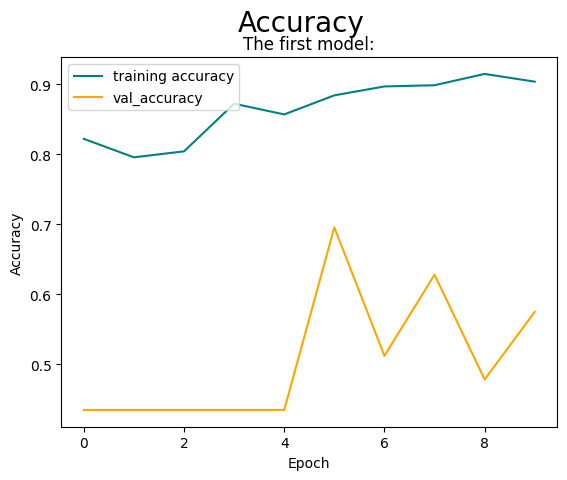

In [27]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('The first model:')
plt.show()

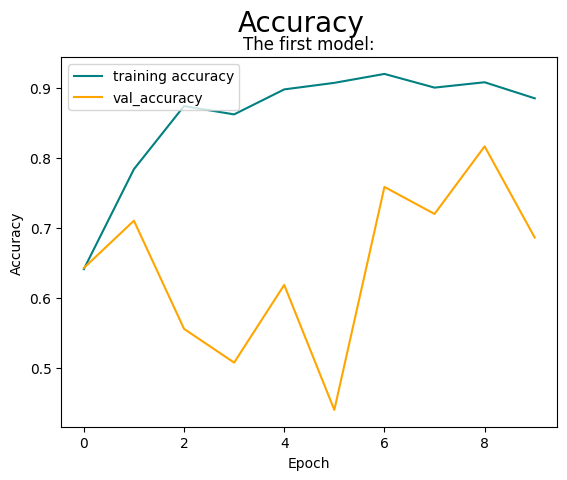

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('The second model:')
plt.show()

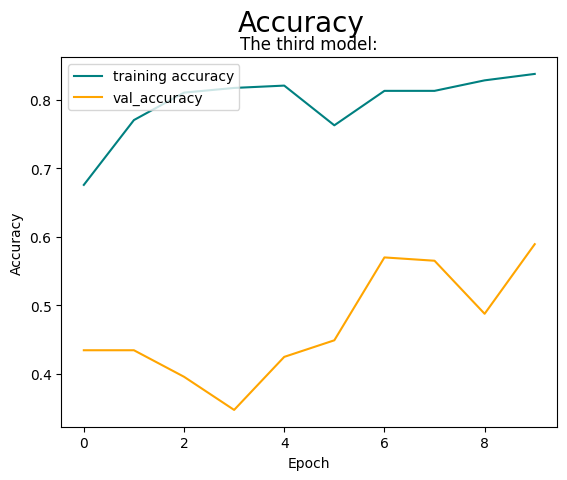

In [38]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('The third model:')
plt.show()

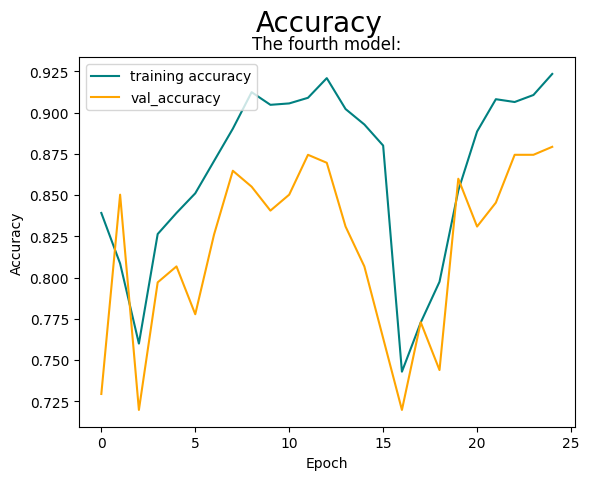

In [44]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('The fourth model:')
plt.show()

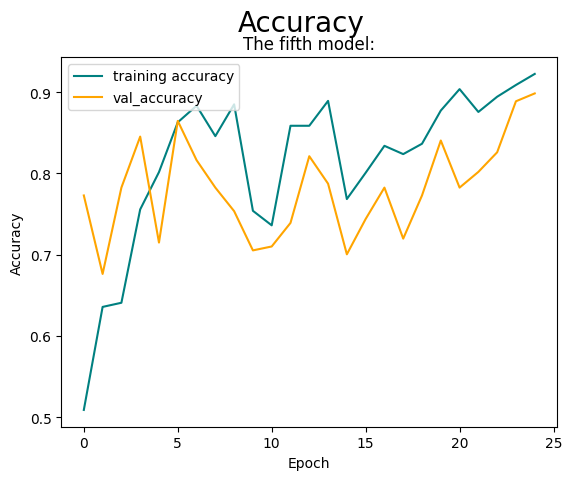

In [51]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('The fifth model:')
plt.show()

## Save the Model
Save the trained CNN model for submission.

In [52]:
model.save("my_model.keras")

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., resizing images, normalization, data augmentation). How do these preprocessing steps improve the performance of your CNN model?
2. **Model Architecture**: Describe the architecture of your CNN model (e.g., number of convolutional layers, kernel sizes, pooling layers). Why did you choose this structure, and how do you expect each layer to contribute to feature extraction?
3. **Activation Functions**: Justify your choice of activation functions. How do they influence the training and output of your CNN?
4. **Training Process**: Discuss your choice of batch size, number of epochs, and optimizer. How did these decisions impact the training process and the convergence of the model?
5. **Loss Function and Metrics**: Explain why you chose the specific loss function and evaluation metrics for this classification task. How do they align with the goal of correctly classifying parkinglot?
6. **Regularization Techniques**: If you used regularization methods like dropout or batch normalization, explain why you implemented them and how they helped prevent overfitting in your model.
7. **Model Evaluation**: Justify the method you used to evaluate your model's performance on the test set. Why did you select these evaluation techniques, and what insights did they provide about your model's accuracy and generalization ability?
8. **Model Visualization**: Explain the significance of the performance visualizations (e.g., accuracy and loss curves). What do they tell you about your model's training process and its ability to generalize?
9. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?

### Answer Here:




*  NOTE: Sorry for any typos.


*   1-The choice for augmentation methods and data preprocessing techniques is purley up to the user's decision, certain things are mandetory like rescaling images by dividing them by 255 to normalize our pixales in the image. Since our data set doesn't really have any inherit dependency on color grey scaling the images would make for an easier time for the model, now for my sequential data augmentation model the user has the ability to pick what ever technique they'd like for example the random zooming or the random rotation which aims to mitigate the possibility of overfitting our model.







*   2-Well as described in my modeling comments, building a model is really about triel and error, I designed a couple of models with a random start of layers untill I got a feel to what is the appropriate amount of layers in my model is.








*   3-Agian when building a CNN model your working blindfolded untill you find you find a flow that you can follow, when choosing the ReLu activation function there really is no specific reason other than the fact that it's the most commonly used function, now if given more time trying different function like the leaky ReLu or tanh would be nice.







*   4-The adam optimizer proved again and agian that's it far and away the best DEFUALT optimizer so as we like to say in this field you should really try all the options as you can't really understand the blackbox that is your model. Now for the number of epochs it really dependeds on the performance of my laptop and how much it can handle, batch size is unspecefied as it sets different batch sizes to every epoch






*   5-Since the subject at hand was a clasification case with a binary output I chose the loss function (binary_crossentropy) as it best expresses the accuracy.







*   6-Model 3 had certain regularization techniques applied that did't really help it as it led to underfitting although only a small amount was used.








*   8-Well for visualization I plotted the accuracies of my models, showing their progression as the epochs went.













*   9-Ah the bias and varience tradeoff the nightmare of any AI engineer, overfitting could occur for many reassons, if our data was imbalanced that could easily lead to overfitting, if our model was too complex for a given dataset that will most likely lead to overfitting take model 3 for example, so you go to make the model less complex like in model 4 and so it leads to inderfitting but in my case thankfully it didn't.  








